<a href="https://colab.research.google.com/github/NadAAaHH/EDA_Project/blob/main/MTA_Turnstile_data_MVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MTA Turnstile data: MVP
The goal of the project is to predict the stations with the highest traffic in the upcoming Summer based on the data from previous Summers. The data of June, July, and August in 2019 was loaded into Python to explored. (the data of 2020 was purposely ignored because of the pandamic impact on the patterns in data)

### Load the data form the server

In [53]:
import sqlalchemy as db
import psycopg2
import pandas as pd

In [54]:
# create an engine from a URL

ENDPOINT = "myinstance.c23ns9ujqnny.us-east-2.rds.amazonaws.com"
PORT = "5431"
USR = "thisadmin"
PSSWD = "pass1234"
DBNAME = "mydb"

URL_DB = "postgresql://{}:{}@{}:{}/{}".format(USR, PSSWD, ENDPOINT, PORT, DBNAME)
engine = db.create_engine(URL_DB, connect_args={'connect_timeout': 300})
print("connection OK")

connection OK


In [55]:
# load the data of Summer 2019 from Server

def get_data_parse_dt(engine, all_tables):
    query = 'SELECT * FROM public."{}";'
    dfs = []
    for table in all_tables:
        query_table = query.format(table)
        dfs.append(pd.read_sql(sql=query_table, con=engine, parse_dates=[['DATE','TIME']]))
    return pd.concat(dfs)
        
all_tables = engine.table_names()
turnstiles_df = get_data_parse_dt(engine, all_tables)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  # This is added back by InteractiveShellApp.init_path()


### Data Cleaning

In [56]:
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5583049 entries, 0 to 205264
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   C/A       object 
 1   UNIT      object 
 2   SCP       object 
 3   STATION   object 
 4   LINENAME  object 
 5   DIVISION  object 
 6   DATE      object 
 7   TIME      object 
 8   DESC      object 
 9   ENTRIES   float64
 10  EXITS     float64
dtypes: float64(2), object(9)
memory usage: 511.1+ MB


In [57]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,00:00:00,REGULAR,7080105.0,2398899.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,04:00:00,REGULAR,7080137.0,2398904.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,08:00:00,REGULAR,7080161.0,2398937.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,12:00:00,REGULAR,7080276.0,2399025.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,16:00:00,REGULAR,7080520.0,2399084.0


In [58]:
# remove whitespaces from columns names
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [59]:
import datetime

In [60]:
# merge the date and time columns into a single datetime column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [61]:
# sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique for ENTRIES
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values(["ENTRIES", "STATION"], ascending=False)).head(55)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
1796773,R101,R001,02-00-00,SOUTH FERRY,2019-08-22 05:00:00,4
2388681,R290,R161,00-00-00,KINGSBRIDGE RD,2019-06-07 05:00:00,4
2790743,R622,R123,00-00-06,FRANKLIN AV,2019-08-22 04:59:02,4
2791345,R622,R123,00-00-07,FRANKLIN AV,2019-08-22 04:59:02,4
385776,E001,R368,00-00-01,9 AV,2019-07-30 05:00:00,4
2320233,R249,R179,01-05-00,86 ST,2019-06-27 00:00:00,4
2320237,R249,R179,01-05-00,86 ST,2019-06-27 04:00:00,4
2320241,R249,R179,01-05-00,86 ST,2019-06-27 08:00:00,4
2320244,R249,R179,01-05-00,86 ST,2019-06-27 12:00:00,4
684966,N045,R187,01-00-00,81 ST-MUSEUM,2019-06-01 17:00:00,4


In [62]:
import datetime

# we have some duplicated entries and exists for same time. Let's check some entries to understand the error
mask = ((turnstiles_df["C/A"] == "R101") & 
(turnstiles_df["UNIT"] == "R001") & 
(turnstiles_df["SCP"] == "02-00-00") & 
(turnstiles_df["STATION"] == "SOUTH FERRY") &
(turnstiles_df["DATE_TIME"].dt.date == datetime.datetime(2019, 8, 22).date()))

turnstiles_df[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
2610323,R101,R001,02-00-00,SOUTH FERRY,1RW,IRT,08/22/2019,01:00:00,REGULAR,3559356.0,5452274.0,2019-08-22 01:00:00
2610324,R101,R001,02-00-00,SOUTH FERRY,1RW,IRT,08/22/2019,05:00:00,REGULAR,3559385.0,5452303.0,2019-08-22 05:00:00
2610325,R101,R001,02-00-00,SOUTH FERRY,1RW,IRT,08/22/2019,05:00:00,RECOVR AUD,3559384.0,5452303.0,2019-08-22 05:00:00
2610326,R101,R001,02-00-00,SOUTH FERRY,1RW,IRT,08/22/2019,09:00:00,REGULAR,3559868.0,5452791.0,2019-08-22 09:00:00
2610327,R101,R001,02-00-00,SOUTH FERRY,1RW,IRT,08/22/2019,13:00:00,REGULAR,3560128.0,5453294.0,2019-08-22 13:00:00


In [63]:
mask = ((turnstiles_df["C/A"] == "E001") & 
(turnstiles_df["UNIT"] == "R368") & 
(turnstiles_df["SCP"] == "00-00-01") & 
(turnstiles_df["STATION"] == "9 AV") &
(turnstiles_df["DATE_TIME"].dt.date == datetime.datetime(2019, 7, 30).date()))

turnstiles_df[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
27808,E001,R368,00-00-01,9 AV,D,BMT,07/30/2019,01:00:00,REGULAR,3499282.0,2678138.0,2019-07-30 01:00:00
27809,E001,R368,00-00-01,9 AV,D,BMT,07/30/2019,05:00:00,REGULAR,3499299.0,2678143.0,2019-07-30 05:00:00
27810,E001,R368,00-00-01,9 AV,D,BMT,07/30/2019,05:00:00,RECOVR AUD,3499298.0,2678143.0,2019-07-30 05:00:00
27811,E001,R368,00-00-01,9 AV,D,BMT,07/30/2019,09:00:00,REGULAR,3499692.0,2678239.0,2019-07-30 09:00:00
27812,E001,R368,00-00-01,9 AV,D,BMT,07/30/2019,13:00:00,REGULAR,3499944.0,2678340.0,2019-07-30 13:00:00


In [64]:
# it seems that the duplicated rows are just missed audits. Let's drop them
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [65]:
# sanity check to verify that all duplicated entries are removed
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values(["ENTRIES", "STATION"], ascending=False)).head(55)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
2542733,R419,R326,00-00-00,ZEREGA AV,2019-05-25 01:00:00,1
2542734,R419,R326,00-00-00,ZEREGA AV,2019-05-25 05:00:00,1
2542735,R419,R326,00-00-00,ZEREGA AV,2019-05-25 09:00:00,1
2542736,R419,R326,00-00-00,ZEREGA AV,2019-05-25 13:00:00,1
2542737,R419,R326,00-00-00,ZEREGA AV,2019-05-25 17:00:00,1
2542738,R419,R326,00-00-00,ZEREGA AV,2019-05-25 21:00:00,1
2542739,R419,R326,00-00-00,ZEREGA AV,2019-05-26 01:00:00,1
2542740,R419,R326,00-00-00,ZEREGA AV,2019-05-26 05:00:00,1
2542741,R419,R326,00-00-00,ZEREGA AV,2019-05-26 09:00:00,1
2542742,R419,R326,00-00-00,ZEREGA AV,2019-05-26 13:00:00,1


In [66]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [67]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [68]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [69]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["TRAFFIC"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

617.0 3124306.0
724.0 3557590.0
458818.0 12875905.0
1376283.0 8703.0
459027.0 68448066.0
371.0 4317056.0
2000091967.0 6897017.0
703.0 2029641260.0
1790.0 13967417.0
14.0 2997591.0
5327469.0 4320256.0
4320262.0 2920966.0
221.0 7246254.0
4050694.0 5902992.0
7246468.0 4050451.0
524600.0 5853002.0
592067.0 57022593.0
276.0 5420884.0
721000.0 5343048.0
190.0 3407197.0
1561.0 1653403.0
241.0 17135546.0
5571815.0 104607574.0
459063.0 4526857.0
22.0 2129136913.0
21.0 13593868.0
27.0 7808626.0
458752.0 117849318.0
1658.0 4588920.0
1962917548.0 9137598.0
228.0 1393341.0
286.0 3466273.0
393224.0 117441229.0
23.0 2130520.0
1828703861.0 9687851.0
126.0 4086499.0
352361625.0 1409587.0
1834.0 2588198.0
77.0 3260283.0
251.0 3376441.0
279.0 3839324.0
1201.0 4720992.0
1337.0 4676887.0
607.0 621485338.0
983783.0 3670905.0
164.0 1788069.0
1325342697.0 11664580.0
149.0 1252883.0
580.0 1650137.0
820.0 1523029.0
366.0 1047791.0
840.0 1251816.0
634.0 1572569.0
857.0 3126422.0
1113.0 1946726.0
1057.0 1214910.0

In [70]:
turnstiles_daily.head(5)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,TRAFFIC
1,A002,R051,02-00-00,59 ST,05/26/2019,7073114.0,05/25/2019,7072456.0,658.0
2,A002,R051,02-00-00,59 ST,05/27/2019,7073837.0,05/26/2019,7073114.0,723.0
3,A002,R051,02-00-00,59 ST,05/28/2019,7075260.0,05/27/2019,7073837.0,1423.0
4,A002,R051,02-00-00,59 ST,05/29/2019,7076789.0,05/28/2019,7075260.0,1529.0
5,A002,R051,02-00-00,59 ST,05/30/2019,7078273.0,05/29/2019,7076789.0,1484.0


In [71]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"]).TRAFFIC.sum().reset_index()
station_daily.head()

,STATION,DATE,TRAFFIC
0,1 AV,05/26/2019,5172.0
1,1 AV,05/27/2019,4808.0
2,1 AV,05/28/2019,16825.0
3,1 AV,05/29/2019,18800.0
4,1 AV,05/30/2019,18948.0


In [72]:
station_totals = station_daily.groupby('STATION').sum()\
    .sort_values('TRAFFIC', ascending=False)\
    .reset_index()

station_totals.head(5)

,STATION,TRAFFIC
0,GRD CNTRL-42 ST,15389479.0
1,34 ST-PENN STA,14328622.0
2,34 ST-HERALD SQ,11040604.0
3,23 ST,10816763.0
4,PATH NEW WTC,10452141.0


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns


In [74]:
total_ridership_per_station = turnstiles_daily.groupby("STATION").TRAFFIC.sum().reset_index().sort_values("TRAFFIC", ascending=False)
total_ridership_per_station

,STATION,TRAFFIC
232,GRD CNTRL-42 ST,15389479.0
61,34 ST-PENN STA,14328622.0
59,34 ST-HERALD SQ,11040604.0
46,23 ST,10816763.0
314,PATH NEW WTC,10452141.0
...,...,...
143,BEACH 44 ST,62002.0
353,TOMPKINSVILLE,56701.0
140,BEACH 105 ST,41595.0
161,BROAD CHANNEL,27226.0


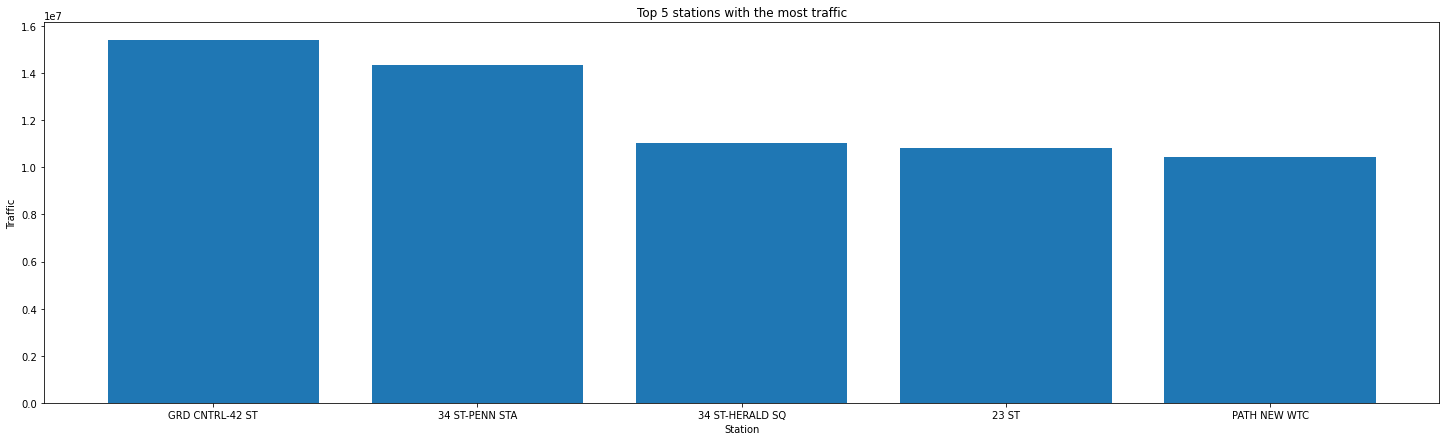

In [75]:
total_ridership_counts = total_ridership_per_station.TRAFFIC
indices = range(len(total_ridership_counts))
plt.figure(figsize=(25, 7))
plt.xlabel("Station")
plt.ylabel("Traffic")
plt.title("Top 5 stations with the most traffic")
plt.bar(total_ridership_per_station.STATION[:5], total_ridership_counts[:5]);

In [76]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"]).TRAFFIC.sum().reset_index()
station_daily.head()

,STATION,DATE,TRAFFIC
0,1 AV,05/26/2019,5172.0
1,1 AV,05/27/2019,4808.0
2,1 AV,05/28/2019,16825.0
3,1 AV,05/29/2019,18800.0
4,1 AV,05/30/2019,18948.0


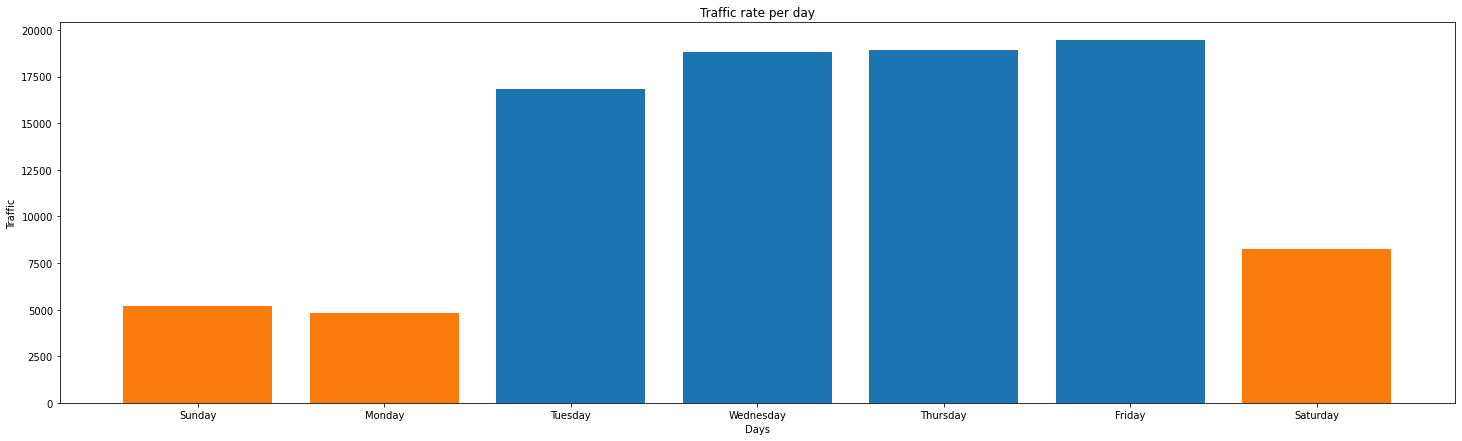

In [77]:
station_daily['DATE'] = pd.to_datetime(station_daily['DATE'])
days = station_daily['DATE'].dt.day_name().unique()

plt.figure(figsize=(25, 7))
plt.xlabel("Days")
plt.ylabel("Traffic")
plt.title("Traffic rate per day")
plt.bar(days, station_daily.TRAFFIC[:7], color=['#fb7c0c', '#fb7c0c', '#1c74b3', '#1c74b3', '#1c74b3', '#1c74b3', '#fb7c0c']);